In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from sklearn.model_selection import train_test_split


from hmmlearn import hmm
import script.DataTypeConverter as dc


np.random.seed(46)

3968
3968
7936


<function matplotlib.pyplot.show(*args, **kw)>

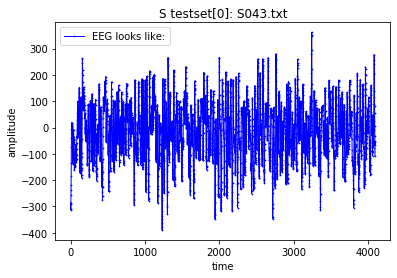

In [21]:
#Read EEG dataset
from os import listdir
# Z: normal but with eyes open
datapath_Z = 'dataset/EEG/Z' 
# O: normal but with eyes closed
datapath_O = 'dataset/EEG/O'
# S: ictal state and contains seizure activities
datapath_S = 'dataset/EEG/S'
# N: hippocampal formation of the opposite brain hemisphere
datapath_N = 'dataset/EEG/N'
# F: epileptogenic zone
datapath_F = 'dataset/EEG/F'

files_Z = [f for f in listdir(datapath_Z)]
files_O = [f for f in listdir(datapath_O)]
files_S = [f for f in listdir(datapath_S)]
files_N = [f for f in listdir(datapath_N)]
files_F = [f for f in listdir(datapath_F)]

Z_train, Z_test = train_test_split(
    files_Z, test_size = 0.3)

S_train, S_test = train_test_split(
    files_S, test_size = 0.3)

data_Z_train = np.loadtxt(datapath_Z + '/' + Z_train[0])[0:128]
data_Z_train_len = [len(data_Z_train)]
for file in Z_train:
    data_file = np.loadtxt(datapath_Z + '/' + file)[0:128]
    data_Z_train = np.concatenate([data_Z_train, data_file])
    data_Z_train_len.append(len(data_file))

plt.plot(np.loadtxt(datapath_Z + '/' + Z_train[0]), ".-", label="EEG looks like:", color = 'b',linewidth = 1, markersize = 1.5)
plt.xlabel("time")
plt.ylabel("amplitude")
#plt.yscale("symlog")
plt.title("Z trainset[0]:"+ Z_train[0])
plt.savefig('Z_1.png', dpi=2000)
plt.legend()
plt.show

data_Z_test = np.loadtxt(datapath_Z + '/' + Z_test[0])[0:128]
data_Z_test_len = [len(data_Z_test)]
for file in Z_test:
    data_file = np.loadtxt(datapath_Z + '/' + file)[0:128]
    data_Z_test = np.concatenate([data_Z_test, data_file])
    data_Z_test_len.append(len(data_file))
my_file = open("./dataset_coe/Z_data.coe", "w")
my_file.write("memory_initialization_radix=16;")
my_file.write("memory_initialization_vector=")
for i in data_Z_test:
    my_file.write("%s \n" %dc.Dec2hex(i, 32, 20, signedness = "signed")[2:])
my_file.close()    
print(len(data_Z_test))
data_S_test = np.loadtxt(datapath_S + '/' + S_test[0])[0:128]
data_S_test_len = [len(data_S_test)]
for file in S_test:
    data_file = np.loadtxt(datapath_S + '/' + file)[0:128]
    data_S_test = np.concatenate([data_S_test, data_file])
    data_S_test_len.append(len(data_file))
my_file = open("./dataset_coe/S_data.coe", "w")
my_file.write("memory_initialization_radix=16;")
my_file.write("memory_initialization_vector=")
for i in data_Z_test:
    my_file.write("%s \n" %dc.Dec2hex(i, 32, 20, signedness = "signed")[2:])
my_file.close() 
print(len(data_S_test)) 

data_test_all = np.concatenate([data_Z_test, data_S_test])
my_file = open("./dataset_coe/data_all.coe", "w")
my_file.write("memory_initialization_radix=16;")
my_file.write("memory_initialization_vector=")
for i in data_Z_test:
    my_file.write("%s \n" %dc.Dec2hex(i, 32, 20, signedness = "signed")[2:])
my_file.close() 
print(len(data_test_all)) 



plt.cla()
plt.plot(np.loadtxt(datapath_S + '/' + S_test[0]), ".-", label="EEG looks like:", color = 'b',linewidth = 1, markersize = 1.5)
plt.xlabel("time")
plt.ylabel("amplitude")
#plt.yscale("symlog")
plt.title("S testset[0]: "+ S_test[0])
plt.savefig('S_1.png', dpi=2000)
plt.legend()
plt.show
#test_data = np.concatenate([data_Z_test, data_S_test])
#test_data_len = np.concatenate([data_Z_test_len, data_S_test_len])

In [20]:
#train hmm for ECG dataset 
EEG_HMM = hmm.GaussianHMM(n_components = 3, covariance_type = "full")
EEG_HMM.fit(data_Z_train.reshape(-1,1), lengths = data_Z_train_len)
# store the model parameters

my_file = open("./Model_Parameters/N_Components.txt", "w")
my_file.write(str(EEG_HMM.n_components))
my_file.close()

my_file = open("./Model_Parameters/Initial_Probability_Matrix.txt", "w")
for i in EEG_HMM.startprob_:
    my_file.write("%s \n" %dc.Dec2hex(i, 32, 20, signedness = "signed"))
my_file.close()

my_file = open("./Model_Parameters/Transition_Probability_Matrix.txt", "w")
for row in EEG_HMM.transmat_:
    for i in row:
        my_file.write("%s \n" %dc.Dec2hex(i, 32, 20, signedness = "signed"))
my_file.close()

my_file = open("./Model_Parameters/Expectancy_Matrix.txt", "w")
for row in EEG_HMM.means_:
    for i in row:
        my_file.write("%s \n" %dc.Dec2hex(i, 32, 20, signedness = "signed"))
my_file.close()

my_file = open("./Model_Parameters/Std_Variance_Matrix.txt", "w")
for row in EEG_HMM.covars_:
    for i in row:
        my_file.write("%s \n" %dc.Dec2hex(i, 32, 20, signedness = "signed"))
my_file.close()

In [8]:
score_Z = []
score_S = []
for i in range(len(Z_test)):
    data = data_Z_test[i * data_Z_test_len[i] : (i + 1) * data_Z_test_len[i]]
    score_Z.append(EEG_HMM.score(data.reshape(-1, 1)))
    # print(EGG_HMM.score(data.reshape(-1, 1)))
#print("---------------")
for i in range(len(S_test)):
    data = data_S_test[i * data_S_test_len[i] : (i + 1) * data_S_test_len[i]]
    score_S.append(EEG_HMM.score(data.reshape(-1, 1)))
    # print(EGG_HMM.score(data.reshape(-1, 1)))

<function matplotlib.pyplot.show(*args, **kw)>

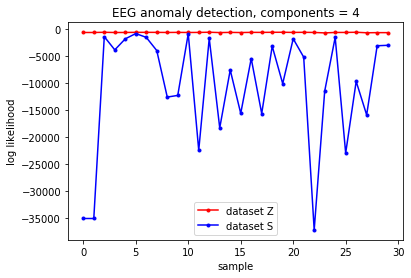

In [9]:
plt.plot(score_Z[:], ".-", label="dataset Z", color = 'r')
plt.plot(score_S[:], ".-", label="dataset S", color = 'b')
plt.xlabel("sample")
plt.ylabel("log likelihood")
#plt.yscale("symlog")
plt.title("EEG anomaly detection, components = 4")
plt.legend()
plt.savefig('EEGscore.png', dpi=2000)
plt.show

In [7]:
print("%s \n" %dc.Dec2hex(-2.565648, 32, 29, signedness = "signed"))

0xade6362b 

